# Solving Viscous Wave Equation

This notebook is used to solve the particular viscous wave equation for the setup of a muon passing through liquid Xenon. The goal is to find the pressure distribution in a container and its decay as a function of distance and time.

## Wave equation

We can derive the viscous wave equation through the linearised Navier-Stokes Equations. The full derivation is in the notes, but the point is that we have added a single term that takes into account the viscous effects. The equation turns out to be as follows:

$$\Delta \left(p(\vec{x},t) - \frac{1}{\omega_0}\frac{\partial}{\partial t}p(\vec{x},t)\right) = \frac{1}{c^2} \frac{\partial}{\partial}p(\vec{x},t)$$

where $c$ is the speed of the wave in the medium, $\omega_0$ is the coefficient responsible for damping, and $p(\vec{x},t)$ is pressure as a function of space and time.

We now introduce the linear differential operator $\mathcal{L}$.

$$\mathcal{L} := \Delta \left(p(\vec{x},t) - \frac{1}{\omega_0}\frac{\partial}{\partial t}p(\vec{x},t)\right) - \frac{1}{c^2} \frac{\partial}{\partial}p(\vec{x},t)$$

## Fundamental Solution

Now we search for the fundamental solution $F(\vec{x},t)$ that satisfies the follwing.

$$\mathcal{L}F(\vec{x},t) = \delta (\vec{x})\delta(t)$$

We can solve it using fourier methods and then we obtain the fundamental solution in terms of this integral over fourier momentum. Now we just need to evaluate this.

$$F(\vec{x},t) = \Theta(t) \int_0^\infty 8\pi^2 c^2 k^2 e^{-\frac{c^2 k^2}{2 \omega_0}t} \frac{e^{i k r} - e^{-ikr}}{2ikr} \frac{e^{ikct\sqrt{1-\frac{k^2c^2}{4\omega_0}}} - e^{-ikct\sqrt{1-\frac{k^2c^2}{4\omega_0}}}}{2ikct\sqrt{1-\frac{k^2c^2}{4\omega_0}}}dk$$

Where $\Theta(t)$ is the Heaviside function and $r:=\left| \vec{x}\right|$

## Numerical Integration

To numerically evaluate this expression we first need to study it. Therefore let's define the function f as the inner part of the integral like so.

$$F(\vec{x},t) = \Theta(t)\int_0^\infty f(k;\vec{x},t)dk$$

Now we realise that the function f is a piecewise function plotted below.

In [2]:
#import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import ipywidgets as widgets

%matplotlib notebook

# Define the relevant constants
c   = 1    # Speed of wave
w_0 = 1    # Damping frequency

# Define integrable function f
def f(k,r,t):
    if t < 0:
        return 0
    
    if k <= 0:
        return 0;
    
    if k < 2*w_0/c:
        return 8 * np.pi**2 * c**2 * k**2 * np.exp(-c**2 * k**2 * t / (2 * w_0)) *\
                np.sinc(k*c*t/np.pi *(1 - k**2 * c**2 / (4 * w_0**2))**0.5) *\
                np.sin(r*k)/(r*k)
    
    elif k > 2*w_0/c:
        return 8 * np.pi**2 * c**2 * k**2 *\
                (np.exp(k*c*t *(-1 + k**2 * c**2 / (4 * w_0**2))**0.5 - c**2 * k**2 * t / (2 * w_0)) -\
                np.exp(-k*c*t *(-1 + k**2 * c**2 / (4 * w_0**2))**0.5 - c**2 * k**2 * t / (2 * w_0)))/\
                (2*k*c*t *(-1 + k**2 * c**2 / (4 * w_0**2))**0.5 ) * np.sin(r*k)/(r*k)
    else: return 0
    
# Define the envelope function of f
def e(k,r,t):
    if t < 0:
        return 0
    
    if k <= 0:
        return 0;
    
    if k < 2*w_0/c:
        return 8 * np.pi**2 * c**2 * np.exp(-c**2 * k**2 * t / (2 * w_0))/\
                (k*r*c*t *(1 - k**2 * c**2 / (4 * w_0**2))**0.5)
    
    elif k > 2*w_0/c:
        return 8 * np.pi**2 * c**2 * k**2 *\
                (np.exp(k*c*t *(-1 + k**2 * c**2 / (4 * w_0**2))**0.5 - c**2 * k**2 * t / (2 * w_0)) -\
                np.exp(-k*c*t *(-1 + k**2 * c**2 / (4 * w_0**2))**0.5 - c**2 * k**2 * t / (2 * w_0)))/\
                (2*k*c*t *(-1 + k**2 * c**2 / (4 * w_0**2))**0.5 )/(r*k)
    else: return 0

<IPython.core.display.Javascript object>


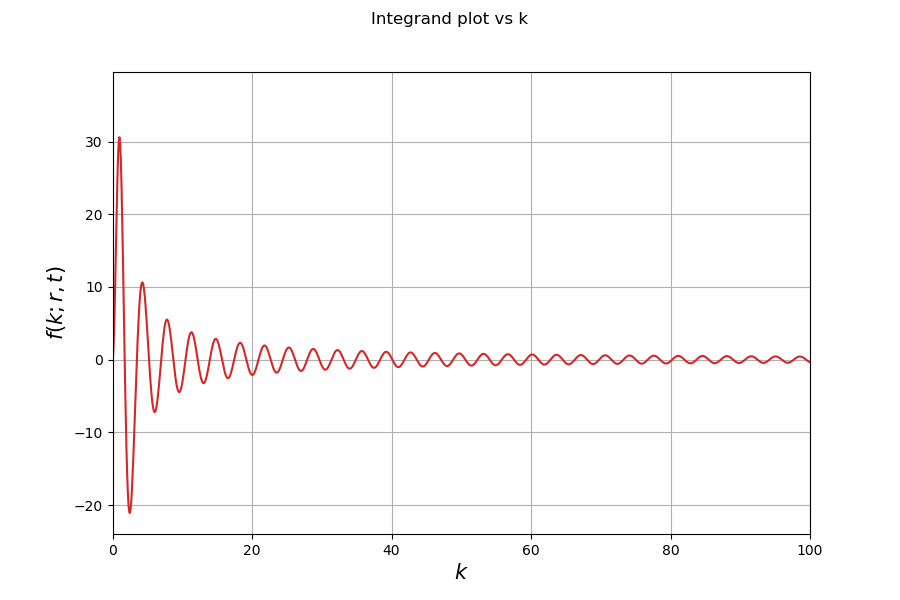

interactive(children=(FloatSlider(value=1.0, description='r', min=0.001), FloatSlider(value=1.0, description='…

In [8]:
# Set up the plot
fig = plt.figure('Integrand plot',figsize=(9,6))
fig.suptitle("Integrand plot vs k")
ax = plt.subplot(111)

k_min = 0
k_max = 100
Npts = 100

ax.set_xlim([k_min, k_max])
ax.set_ylabel(r'$f(k;r,t)$',fontsize = 15)
ax.set_xlabel(r'$k$',fontsize = 15)
ax.grid(True)

# Generate x-y values
k = np.linspace(k_min,k_max,Npts)
def f_vect(K,r,t):
    return np.array([f(k,r,t) for k in K])

# Add the sliders
@widgets.interact(r=(0.001, 100, 0.1), t=(0.001, 10, .01), Npts=(100,10000, 1))
def update(r = 1.0, t=1.0, Npts=1000):
    [l.remove() for l in ax.lines]
    k = np.linspace(k_min,k_max,Npts)
    ax.plot(k, f_vect(k,r,t), color='C3')

# Integration

Now that we have the plot we need to somehow integrate it. To do this efficiently we need to find when does the wave decay over a specific amount. As a result we need to find its envelope. To do this we have to study each of the pieces of the piecewise function seperately.

Now based on the analytic expression of the integrand we can conclude that the envelope function $\varepsilon(k;r,t)$ is the following.

$$\varepsilon(k;r,t) = 8\pi^2 c^2 e^{-\frac{c^2 k^2}{2 \omega_0}t}\frac{1}{krct\sqrt{1-\frac{k^2c^2}{4\omega_0}}}dk$$

Let's try to plot one against the other

<IPython.core.display.Javascript object>


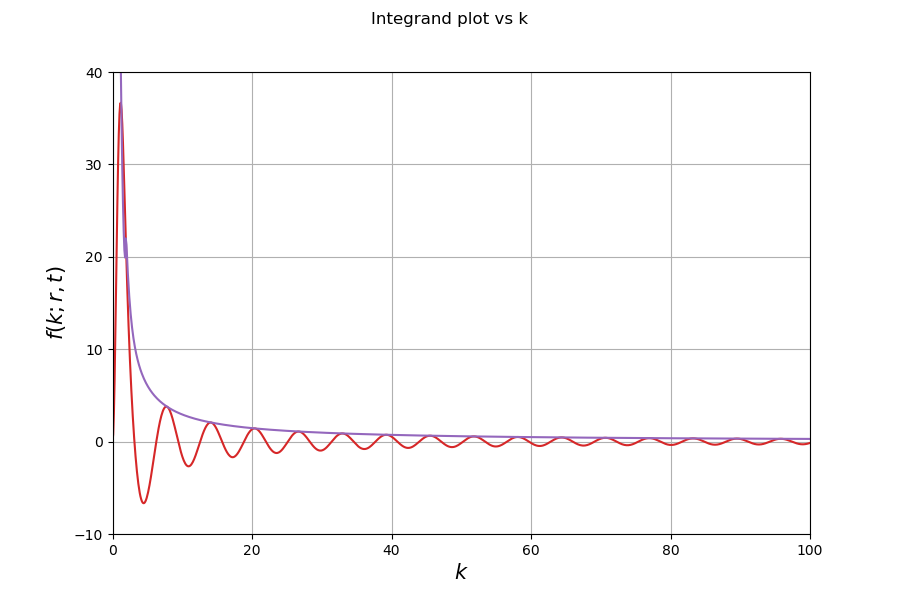

interactive(children=(FloatSlider(value=1.0, description='r', min=0.001), FloatSlider(value=1.0, description='…

In [15]:
# Set up the plot
fig2 = plt.figure('Integrand plot2',figsize=(9,6))
fig2.suptitle("Integrand plot vs k")
ax2 = plt.subplot(111)

k_min = 0
k_max = 100
Npts = 100

ax2.set_ylim([-10, 40])
ax2.set_xlim([k_min, k_max])
ax2.set_ylabel(r'$f(k;r,t)$',fontsize = 15)
ax2.set_xlabel(r'$k$',fontsize = 15)
ax2.grid(True)

# Generate x-y values
k2 = np.linspace(k_min,k_max,Npts)
def f_vect(K,r,t):
    return np.array([f(k,r,t) for k in K])

def e_vect(K,r,t):
    return np.array([e(k,r,t) for k in K])

# Add the sliders
@widgets.interact(r=(0.001, 100, 0.1), t=(0.001, 10, .01), Npts=(100,10000, 1))
def update2(r = 1.0, t=1.0, Npts=1000):
    [l.remove() for l in ax2.lines]
    k2 = np.linspace(k_min,k_max,Npts)
    ax2.plot(k2, f_vect(k2,r,t), color='C3')
    ax2.plot(k2, e_vect(k2,r,t), color='C4')

Now it is easy to see how to find a limit for our integration. Specifically we can use this envelope equation to calculate the maximum $k$ to integrate to based on a small number $\delta$ given by the user.